In [354]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Datos

In [355]:
# path = 'D:/Users/maryskal/Documents/SITK/CXR8/images/images_001'
path = '/home/mr1142/Documents/Data/segmentation/splited/train'

In [356]:
masks_name = [f for f in os.listdir(os.path.join(path, 'mascara')) 
              if os.path.isfile(os.path.join(os.path.join(path, 'mascara'), f))]

In [357]:
pixels = 256

In [358]:
def read_img(path, folder, img):
    img = cv2.imread(os.path.join(path, folder, img))
    img = prepare_img(img)
    return img

In [359]:
def prepare_img(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pixels, pixels))
    img = np.expand_dims(img, axis=-1)
    return img

In [360]:
def normalize(img):
    return (img - np.mean(img))/ np.std(img)

In [361]:
def binarize(img):
    img[img>0] = 1
    return img

In [373]:
def apply_to_tensor(tensor, func):
    for i in range(tensor.shape[0]):
        tensor[i,...] = func(tensor[i,...])
    return tensor

In [362]:
def clahe(img):
    clahe = cv2.createCLAHE()
    final_img = np.expand_dims(clahe.apply(img), axis=-1)
    return final_img

In [363]:
masks = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    masks[i, ...] = binarize(read_img(path, 'mascara', masks_name[i]))

In [364]:
images = np.zeros((len(masks_name), pixels,pixels,1))
for i in range(len(masks_name)):
    images[i, ...] = read_img(path, 'images', masks_name[i])

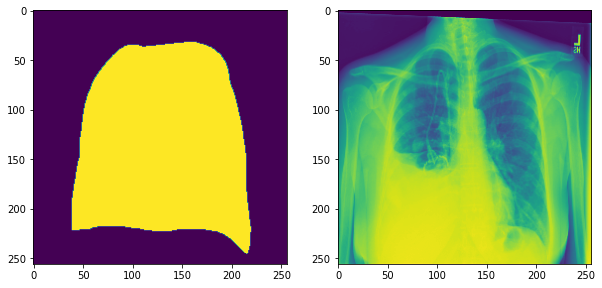

In [365]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(masks[r])
plt.subplot(1,2,2)
plt.imshow(images[r])
plt.show()

In [366]:
images.shape

(393, 256, 256, 1)

# Aumento de datos

In [367]:
import albumentations as A

In [806]:
transform = A.Compose([
    A.Rotate(limit=60, border_mode = None, interpolation=2, p=1),
    A.OneOf([
        # A.RandomCrop(p= 1, width=230, height=230),
        # A.RandomGamma (gamma_limit=(20, 200), eps=None, always_apply=False, p=1),
        A.ElasticTransform(alpha=0.5, sigma=20, alpha_affine=20, interpolation=2, border_mode=None, always_apply=False, p=1),
        A.MotionBlur(blur_limit=5, always_apply=False, p=0.3),
        A.Sharpen(alpha=(0, 1), lightness=(0, 1.0), always_apply=False, p=0.8),
    ], p=1),  
])

In [368]:
transform = A.Compose([
        A.RandomGamma (gamma_limit=(20, 200), eps=None, always_apply=False, p=1),
        A.ElasticTransform(alpha=0.5, sigma=20, alpha_affine=20, interpolation=2, border_mode=None, always_apply=False, p=1),
        A.MotionBlur(blur_limit=5, always_apply=False, p=0.2),
        A.Rotate(limit=60, border_mode = None, interpolation=2, p=1),
        A.RandomCrop(p=0.2, width=250, height=250),
        A.Sharpen(alpha=(0, 1), lightness=(0, 1.0), always_apply=False, p=0.1),
])

In [369]:
r = np.random.randint(0, len(images))
transformed = transform(image=images[r].astype(np.float32), mask=masks[r].astype(np.float32))

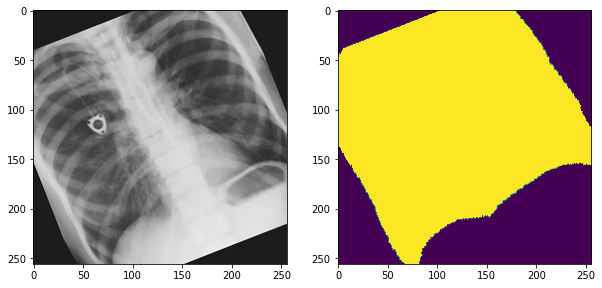

In [370]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(transformed['image'], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(transformed['mask'])
plt.show()

In [371]:
n = images.shape[0]
new_img = np.zeros((n, pixels,pixels,1))
new_mask = np.zeros((n, pixels,pixels,1))
for i in range(n):
    transformed = transform(image=images[i].astype(np.float32), mask=masks[i].astype(np.float32))
    new_img[i, ...] = prepare_img(transformed['image'])
    new_mask[i,...] = prepare_img(transformed['mask'])

In [372]:
images = np.concatenate((new_img, images), axis = 0)
masks = np.concatenate((new_mask, masks), axis = 0)
# importance = np.concatenate((importance, importance), axis=0)

In [375]:
images = apply_to_tensor(images, normalize) 
masks = apply_to_tensor(masks, binarize) 

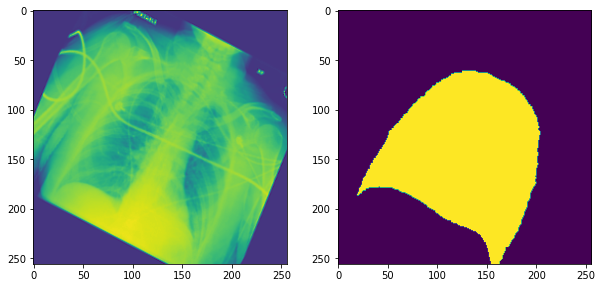

In [415]:
r = np.random.randint(0, len(images))
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(images[r])
plt.subplot(1,2,2)
plt.imshow(masks[r])
plt.show()